<a href="https://colab.research.google.com/github/msbeigi/sale-analysis/blob/main/backery_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirment

In [ ]:
!sudo pip install xgboost
!pip install catboost


In [58]:
import pandas as pd
import numpy as np
from IPython.display import display,HTML
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Initiation and Data Understanding

### Load Data

In [3]:
weather=pd.read_csv("/content/drive/MyDrive/ML/Hand-on/Backery/weather_2021.01.01-2022.10.31.csv")
backery=pd.read_csv("/content/drive/MyDrive/ML/Hand-on/Backery/bakery_sales_2021-2022.csv")
title='<h3>Sample content of Datsets:</h3>'
display(HTML(title))
title='<h3>bakery_sales_2021-2022.csv</h3>'
display(HTML(title))
display(backery.head(7))
title='<h3>weather_2021.01.01-2022.10.31.csv</h3>'
display(HTML(title))
display(weather.head(7))

,Unnamed: 0,date,time,ticket_number,Article,Quantity,UNIT_PRICE
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
5,11,2021-01-02,09:25,150043.0,BAGUETTE,2.0,"0,90 €"
6,12,2021-01-02,09:25,150043.0,CROISSANT,3.0,"1,10 €"


,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-01-01,2.7,1.5,5.7,15.2,NaN,335.0,15.5,31.0,1008.6,NaN
1,2021-01-02,1.3,0.5,2.7,0.8,NaN,336.0,24.7,44.0,1010.1,NaN
2,2021-01-03,0.7,-0.3,1.6,0.0,NaN,327.0,17.1,38.9,1012.1,NaN
3,2021-01-04,0.0,-1.0,1.1,0.0,NaN,329.0,10.6,30.0,1011.4,NaN
4,2021-01-05,0.8,-0.9,2.1,0.0,NaN,338.0,6.2,30.0,1012.1,NaN
5,2021-01-06,0.8,0.2,1.4,0.0,NaN,324.0,8.0,21.0,1015.4,NaN
6,2021-01-07,0.2,-1.6,2.5,0.0,NaN,343.0,6.2,24.0,1017.1,NaN


### Summary Missing Values and Feature Types

In [4]:
meta_backery=['row index' 	,'date of sale ','time of sale ', 'receipt number ','product name ', 'quantity of the product','unit price of the product']
meta_weahter=['The date of the measurement', 'The average air temperature in °C', 'The minimum air temperature in °C','The maximum air temperature in °C'
              ,'The daily precipitation total in mm', 'The snow depth in mm', 'The average wind direction in degrees (°)', 'The average wind speed in km/h'
              ,'The peak wind gust in km/h', 'The average sea-level air pressure in hPa', 'The daily sunshine total in minutes (m)']


missing_values=backery.isna().sum()
missing_values_weather=weather.isna().sum()

feature_typ=backery.dtypes
feature_typ_weather=weather.dtypes

# out put for backery dataset
_=zip(missing_values.index,meta_backery,missing_values.values,feature_typ.values)
df_backer_desc = pd.DataFrame(_, columns=['column','feature_escription', 'number_of_missing_values', 'feature_type']).style.set_properties(**{'text-align': 'left'})
title = "<h3>Backery Dataset Summary with Missing Values and Data Types</h3>"
display(HTML(title))
display(df_backer_desc)
# output for weather dataset
_=zip(missing_values_weather.index,meta_weahter,missing_values_weather.values,feature_typ_weather.values)
df_weather_desc = pd.DataFrame(_, columns=['column','feature_description', 'number_of_missing_values', 'feature_type']).style.set_properties(**{'text-align': 'left'})
title = "<h3>Weather Dataset Summary with Missing Values and Data Types</h3>"
display(HTML(title))
display(df_weather_desc)


,column,feature_escription,number_of_missing_values,feature_type
0,Unnamed: 0,row index,0,int64
1,date,date of sale,0,object
2,time,time of sale,0,object
3,ticket_number,receipt number,0,float64
4,Article,product name,0,object
5,Quantity,quantity of the product,0,float64
6,UNIT_PRICE,unit price of the product,0,object


,column,feature_description,number_of_missing_values,feature_type
0,date,The date of the measurement,0,object
1,tavg,The average air temperature in °C,0,float64
2,tmin,The minimum air temperature in °C,0,float64
3,tmax,The maximum air temperature in °C,0,float64
4,prcp,The daily precipitation total in mm,0,float64
5,snow,The snow depth in mm,654,float64
6,wdir,The average wind direction in degrees (°),2,float64
7,wspd,The average wind speed in km/h,2,float64
8,wpgt,The peak wind gust in km/h,14,float64
9,pres,The average sea-level air pressure in hPa,2,float64


### Statistical Review

In [5]:
title='<h3>Statistical review</h3>'
display(HTML(title))
title='<h4>backery:</h4>'
display(HTML(title))
display(backery.describe())
title='<h4>weather:</h4>'
display(HTML(title))
display(weather.describe())


,Unnamed: 0,ticket_number,Quantity
count,234005.000000,234005.000000,234005.000000
mean,255205.035854,219201.258738,1.538377
std,147501.625992,40053.223896,1.289603
min,0.000000,150040.000000,-200.000000
25%,127979.000000,184754.000000,1.000000
50%,254573.000000,218807.000000,1.000000
75%,382911.000000,253927.000000,2.000000
max,511395.000000,288913.000000,200.000000


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,669.000000,669.000000,669.000000,669.000000,15.000000,667.000000,667.000000,655.000000,667.000000,0.0
mean,13.900747,9.552167,18.830344,2.272945,14.733333,225.757121,12.674813,39.014198,1018.422789,NaN
std,7.710498,6.918623,8.864005,7.402603,9.353889,108.937433,6.022562,14.485416,7.056279,NaN
min,-3.300000,-5.400000,-1.500000,0.000000,10.000000,0.000000,3.100000,11.000000,996.400000,NaN
25%,7.800000,3.800000,12.400000,0.000000,10.000000,155.000000,8.000000,28.000000,1014.200000,NaN
50%,14.200000,9.800000,19.500000,0.000000,10.000000,192.000000,11.300000,37.000000,1018.400000,NaN
75%,20.000000,15.600000,25.500000,0.800000,15.000000,338.500000,16.000000,46.300000,1022.300000,NaN
max,31.800000,24.800000,38.500000,103.400000,41.000000,359.000000,41.000000,93.000000,1039.300000,NaN


## Data preparation

### Missing Values

In [6]:
def drop_nonvalue(df :pd.DataFrame)->pd.DataFrame:
  """
  Args:
    df: weather dataset as dataframe input
  Returns:
    returns cleared dataframe of missing values
  """
  df.drop(['tsun','snow'], axis=1,inplace=True)

  return df

def impute_missing_values(df:pd.DataFrame)->pd.DataFrame:
    """
    Args:
      df: weather dataset as dataframe input
    Returns:
      return the modified DataFrame
    """
    columns_tobe_fill = ['wdir','wspd','wpgt','pres']
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
    df[columns_tobe_fill] = imputer.fit_transform(df[columns_tobe_fill])


    return df

In [7]:
df_weather=weather.copy()
df_weather=drop_nonvalue(df_weather)
df_weather=impute_missing_values(df_weather)
print('Number of missing values:\n----------------')
print(df_weather.isna().sum())


Number of missing values:
----------------
date    0
tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
wpgt    0
pres    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Anomalies

In [8]:
def drop_nodata_bakey(df: pd.DataFrame)->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset without anomaly data
  """
  no_data_indice=df[df['Article']=='.'].index
  df.drop(no_data_indice, inplace=True)
  df['Article'] = df['Article'].str.strip()
  return df

def false_quantity(df: pd.DataFrame)-> pd.DataFrame:

  no_data_indice=df[df['Quantity']<=0]
  df.drop(no_data_indice, inplace=True)

  return df

def false_price(df: pd.DataFrame)-> pd.DataFrame:


  no_data_indice=df[df['UNIT_PRICE']=='0,00 €']
  df.drop(no_data_indice, inplace=True)

  return df


## Feature Engineering

In [9]:
def encode_bakery(df: pd.DataFrame)->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset with encoded Article feature
  """
  label_encoder = LabelEncoder()
  df['Article_Label'] = label_encoder.fit_transform(df['Article'])
  return df


def onehot_encode_bakery(df: pd.DataFrame)  ->pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return dataset with encoded Article feature in oneHot
  """
  encoder = OneHotEncoder(sparse=False)
  article_encoded = encoder.fit_transform(df[['Article']])
  encode_columns=encoder.get_feature_names_out()
  encoded_df=pd.DataFrame(article_encoded,columns=encode_columns)
  df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
  return df

def added_feature_bakery(df: pd.DataFrame)-> pd.DataFrame:
  """
  Args:
   df: bakery dataset as dataframe input
  Returns:
    return new dataset with added feature
  """

  df=df.rename(columns={'Unnamed: 0':'index'})

  df['unit_price_value']= df['UNIT_PRICE'].apply(lambda x: extract_price(x))
  df["total_sale_item"]= df['Quantity']*df['unit_price_value']
  df=df.rename(columns={'Unnamed: 0':'index'})
  df['hour_day']=df['time'].apply(lambda x: pd.to_datetime(x, format='%H:%M').hour)
  df['date'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

  df['day_of_week'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').dayofweek)
  df['day_name']= df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').day_name())
  df['is_weekend'] = df['day_name'].isin(['Saturday', 'Sunday']).astype(int)


  return df

def added_feature_weather(df: pd.DataFrame)-> pd.DataFrame:
  """
  Args:
   df: weather dataset as dataframe input
  Returns:
    return new dataset with added feature
  """
  df['is_rainy']=df['prcp']>0
  df['temp_range'] = df['tmax'] - df['tmin']
  df['is_cold_day'] = (df['tavg'] < 10).astype(int)
  df['is_hot_day'] = (df['tavg'] > 25).astype(int)
  df['is_heavy_wind'] = (df['wspd'] > 20).astype(int)
  df['is_high_pressure'] = (df['pres'] > 1015).astype(int)
  df['date'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

  df['day_of_week'] = df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').dayofweek)
  df['day_name']= df['date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d').day_name())
  df['is_weekend'] = df['day_name'].isin(['Saturday', 'Sunday']).astype(int)


  df['month'] = df['date'].dt.month
  df['week'] = df['date'].dt.isocalendar().week
  df['day'] = df['date'].dt.day

  fr_holidays = holidays.France()
  df['is_holiday'] = df['date'].apply(lambda x: x in fr_holidays)
  return df

def extract_price(price_tag: object)->float:
  """
  Args:
    price_tag: string input for daily sale with currency sign

  Returns:
    returns price value as float
  """
  price_string=str(price_tag)
  price_value=float(price_string[:-2].replace(',','.'))
  return price_value

<Axes: >

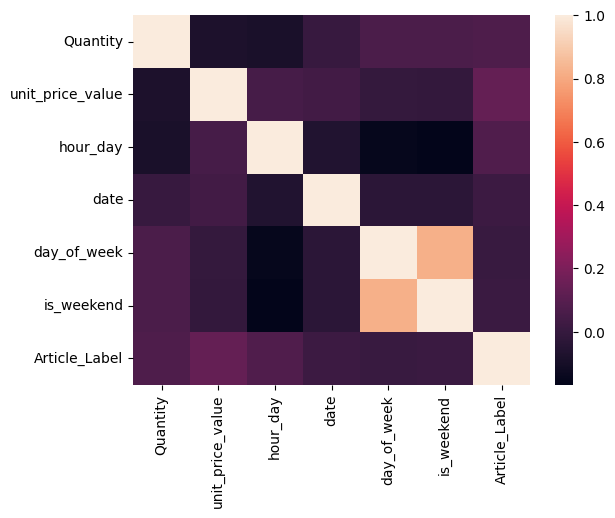

In [10]:
df_bekery=backery.copy()

df_bekery=drop_nodata_bakey(df_bekery)
df_bekery=encode_bakery(df_bekery)
df_backery=added_feature_bakery(df_bekery)
correlation=df_backery[['Quantity','unit_price_value','hour_day','date','day_of_week','is_weekend','Article_Label']].corr()
sns.heatmap(correlation)

In [11]:
df_bekery_one=df_backery.copy()
df_bekery_one=onehot_encode_bakery(df_bekery_one)
df_weather=added_feature_weather(df_weather)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:

no_data_indice=df_backery[df_backery['Quantity']<=0].index
df_backery.drop(no_data_indice, inplace=True,axis=0)
no_data_indice=df_backery[df_backery['UNIT_PRICE']=='0,00 €'].index
df_backery.drop(no_data_indice, inplace=True,axis=0)

df_backery


,index,date,time,ticket_number,Article,Quantity,UNIT_PRICE,Article_Label,unit_price_value,total_sale_item,hour_day,day_of_week,day_name,is_weekend
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €",3,0.90,0.90,8,5,Saturday,1
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €",84,1.20,3.60,8,5,Saturday,1
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €",84,1.20,2.40,9,5,Saturday,1
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €",83,1.15,1.15,9,5,Saturday,1
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €",139,1.20,6.00,9,5,Saturday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234000,511387,2022-09-30,18:52,288911.0,COUPE,1.0,"0,15 €",30,0.15,0.15,18,4,Friday,0
234001,511388,2022-09-30,18:52,288911.0,BOULE 200G,1.0,"1,20 €",10,1.20,1.20,18,4,Friday,0
234002,511389,2022-09-30,18:52,288911.0,COUPE,2.0,"0,15 €",30,0.15,0.30,18,4,Friday,0
234003,511392,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €",139,1.30,1.30,18,4,Friday,0


In [13]:
# df_bekery_one
daily_sale = df_backery[['date', 'Article', 'Quantity', 'total_sale_item']].groupby(['date', 'Article'], as_index=False).sum()


In [14]:
df_daily_sale=encode_bakery(daily_sale)
merged_data = pd.merge(df_daily_sale, df_weather, on='date', how='left')

merged_data

,date,Article,Quantity,total_sale_item,Article_Label,tavg,tmin,tmax,prcp,wdir,...,is_hot_day,is_heavy_wind,is_high_pressure,day_of_week,day_name,is_weekend,month,week,day,is_holiday
0,2021-01-02,BAGUETTE,46.0,41.4,2,1.3,0.5,2.7,0.8,336.0,...,0,1,0,5,Saturday,1,1,53,2,False
1,2021-01-02,BANETTE,40.0,42.0,5,1.3,0.5,2.7,0.8,336.0,...,0,1,0,5,Saturday,1,1,53,2,False
2,2021-01-02,BANETTINE,6.0,3.6,6,1.3,0.5,2.7,0.8,336.0,...,0,1,0,5,Saturday,1,1,53,2,False
3,2021-01-02,BOULE 200G,6.0,6.6,9,1.3,0.5,2.7,0.8,336.0,...,0,1,0,5,Saturday,1,1,53,2,False
4,2021-01-02,BOULE 400G,11.0,16.5,10,1.3,0.5,2.7,0.8,336.0,...,0,1,0,5,Saturday,1,1,53,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29176,2022-09-30,SPECIAL BREAD KG,1.0,5.2,125,10.2,7.0,14.6,0.0,346.0,...,0,0,0,4,Friday,0,9,39,30,False
29177,2022-09-30,SUCETTE,1.0,0.3,127,10.2,7.0,14.6,0.0,346.0,...,0,0,0,4,Friday,0,9,39,30,False
29178,2022-09-30,TARTELETTE,3.0,6.6,133,10.2,7.0,14.6,0.0,346.0,...,0,0,0,4,Friday,0,9,39,30,False
29179,2022-09-30,TRADITIONAL BAGUETTE,141.0,183.3,138,10.2,7.0,14.6,0.0,346.0,...,0,0,0,4,Friday,0,9,39,30,False


,Quantity,total_sale_item,Article_Label,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,...,is_cold_day,is_hot_day,is_heavy_wind,is_high_pressure,day_of_week,is_weekend,month,week,day,is_holiday
Quantity,1.000000,0.942251,0.102927,0.064810,0.061952,0.066054,-0.003575,0.013323,-0.012951,-0.005742,...,-0.045182,0.034549,-0.009688,-0.008221,0.043916,0.052867,0.027606,0.028245,0.003828,0.028770
total_sale_item,0.942251,1.000000,0.188136,0.080410,0.076539,0.081656,-0.005692,0.019002,-0.014453,-0.006180,...,-0.056451,0.046167,-0.011735,-0.011591,0.048894,0.056860,0.031297,0.033904,0.004568,0.035408
Article_Label,0.102927,0.188136,1.000000,0.035258,0.034603,0.035661,-0.000677,0.007921,-0.003254,0.001252,...,-0.028869,0.009749,-0.001216,0.000983,0.038180,0.040427,0.024898,0.021735,0.001789,0.015461
tavg,0.064810,0.080410,0.035258,1.000000,0.966982,0.983593,-0.028687,0.037959,-0.017431,0.103290,...,-0.809051,0.439123,-0.044419,-0.165466,-0.044660,-0.054182,0.329230,0.302840,0.031049,0.030314
tmin,0.061952,0.076539,0.034603,0.966982,1.000000,0.923225,0.033076,0.028960,0.016816,0.124896,...,-0.792569,0.401575,-0.023476,-0.224850,-0.048070,-0.058430,0.369818,0.347188,0.030292,0.026929
tmax,0.066054,0.081656,0.035661,0.983593,0.923225,1.000000,-0.053279,0.043559,-0.046108,0.089950,...,-0.788371,0.436656,-0.064667,-0.136250,-0.034512,-0.039607,0.297027,0.267552,0.031274,0.027121
prcp,-0.003575,-0.005692,-0.000677,-0.028687,0.033076,-0.053279,1.000000,-0.045881,-0.042780,0.008937,...,-0.053521,-0.082840,-0.053162,-0.195930,-0.087077,-0.056217,0.071514,0.064532,-0.032002,0.079471
wdir,0.013323,0.019002,0.007921,0.037959,0.028960,0.043559,-0.045881,1.000000,0.154308,0.055488,...,-0.014467,-0.022311,0.050310,0.098543,-0.002957,0.041676,-0.050648,-0.042163,0.027919,-0.088579
wspd,-0.012951,-0.014453,-0.003254,-0.017431,0.016816,-0.046108,-0.042780,0.154308,1.000000,0.804810,...,0.007155,0.007294,0.721572,-0.091463,0.041999,0.041767,-0.194344,-0.183073,-0.020199,-0.048193
wpgt,-0.005742,-0.006180,0.001252,0.103290,0.124896,0.089950,0.008937,0.055488,0.804810,1.000000,...,-0.094168,0.062747,0.531380,-0.236915,0.055640,0.053078,-0.164743,-0.165745,0.015360,-0.033173


<Axes: >

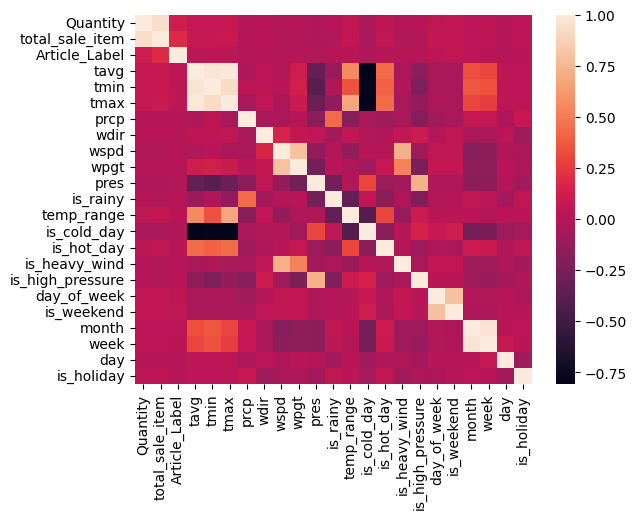

In [15]:


correlation_merge=merged_data[[ 'Quantity', 'total_sale_item', 'Article_Label',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'is_heavy_wind',
       'is_high_pressure', 'day_of_week', 'is_weekend', 'month',
       'week', 'day', 'is_holiday']].corr()
display(correlation_merge)
sns.heatmap(correlation_merge)


In [16]:
# correlation_merge[correlation_merge[]]['Quantity']

correl=dict(correlation_merge['Quantity'])
correl_list=[]
for i in correl:
    if(np.abs(correl[i])>0.01 and i!='Quantity'):
        correl_list.append(i)
print(f'Top features:\n{correl_list}')

Top features:
['total_sale_item', 'Article_Label', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'day_of_week', 'is_weekend', 'month', 'week', 'is_holiday']


### Feature importance

In [17]:
df_train=merged_data[[ 'Article_Label',      'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
                      'is_rainy', 'temp_range', 'is_cold_day', 'is_hot_day', 'is_heavy_wind',
                      'is_high_pressure', 'day_of_week', 'is_weekend', 'month','week', 'day', 'is_holiday']]
df_y=merged_data['Quantity']
df_train

,Article_Label,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,pres,is_rainy,...,is_cold_day,is_hot_day,is_heavy_wind,is_high_pressure,day_of_week,is_weekend,month,week,day,is_holiday
0,2,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1,True,...,1,0,1,0,5,1,1,53,2,False
1,5,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1,True,...,1,0,1,0,5,1,1,53,2,False
2,6,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1,True,...,1,0,1,0,5,1,1,53,2,False
3,9,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1,True,...,1,0,1,0,5,1,1,53,2,False
4,10,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1,True,...,1,0,1,0,5,1,1,53,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29176,125,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7,False,...,0,0,0,0,4,0,9,39,30,False
29177,127,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7,False,...,0,0,0,0,4,0,9,39,30,False
29178,133,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7,False,...,0,0,0,0,4,0,9,39,30,False
29179,138,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7,False,...,0,0,0,0,4,0,9,39,30,False


In [18]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb


X_train,X_test,y_train,y_test=train_test_split(df_train, df_y, test_size=0.3, random_state=42)


etr = ExtraTreesRegressor(n_estimators=300, random_state=42)
etr.fit(X_train, y_train)
feature_importances_etr = etr.feature_importances_

lgbm = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42)
lgbm.fit(X_train, y_train)

feature_importances_lgbm = lgbm.feature_importances_


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 20426, number of used features: 21
[LightGBM] [Info] Start training from score 12.295702


In [28]:
importances = importances.sort_values(by='Importance_ETR', ascending=False)
importances['Feature'].values

array(['Article_Label', 'month', 'week', 'is_weekend', 'tmax', 'tavg',
       'tmin', 'day_of_week', 'day', 'is_holiday', 'temp_range', 'wdir',
       'pres', 'is_cold_day', 'wspd', 'wpgt', 'is_high_pressure', 'prcp',
       'is_rainy', 'is_hot_day', 'is_heavy_wind'], dtype=object)

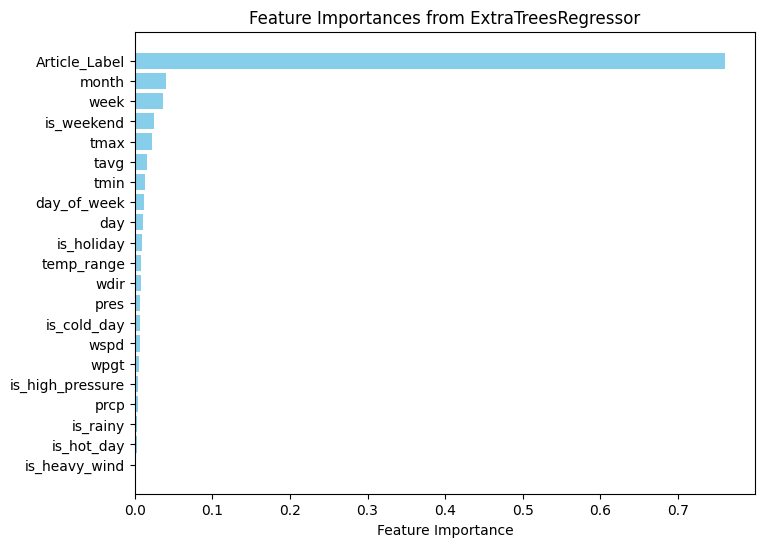


Top features from ExtraTreesRegressor: ['Article_Label' 'month' 'week' 'is_weekend' 'tmax' 'tavg' 'tmin'
 'day_of_week' 'day' 'is_holiday' 'temp_range' 'wdir' 'pres' 'is_cold_day'
 'wspd' 'wpgt' 'is_high_pressure' 'prcp' 'is_rainy']


top features from LGBMRegressor:['Article_Label' 'week' 'day_of_week' 'tmax' 'tmin' 'wdir' 'tavg' 'day'
 'temp_range' 'wspd' 'pres' 'wpgt' 'is_holiday' 'month' 'prcp' 'is_rainy']



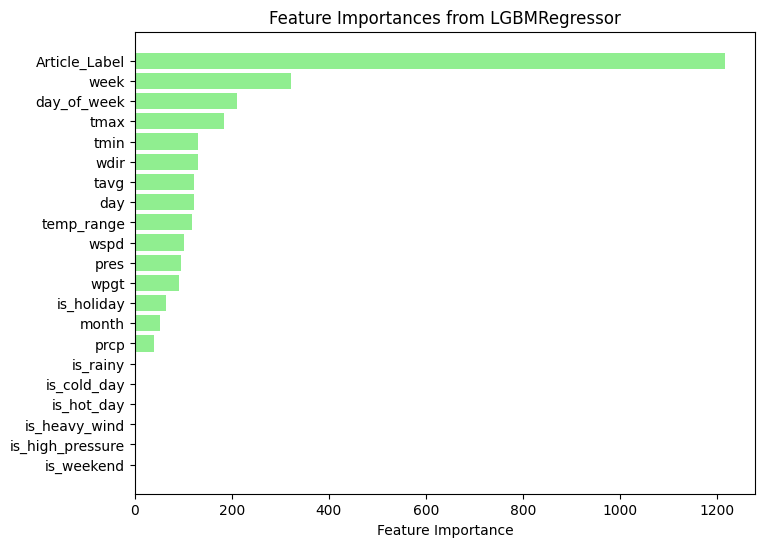

In [35]:
features = X_train.columns
importances = pd.DataFrame({
    'Feature': features,
    'Importance_ETR': feature_importances_etr,
    'Importance_LGBM': feature_importances_lgbm
})

importances_etr = importances.sort_values(by='Importance_ETR', ascending=False)
plt.figure(figsize=(8, 6))
plt.barh(importances_etr['Feature'], importances_etr['Importance_ETR'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from ExtraTreesRegressor')
plt.gca().invert_yaxis()
plt.show()

# importances = importances.sort_values(by='Importance_LGBM', ascending=False)
top_features_etr = importances_etr[:19]['Feature'].values
print(f'\nTop features from ExtraTreesRegressor: {top_features_etr}\n')

importances_lgbm = importances.sort_values(by='Importance_LGBM', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importances_lgbm['Feature'], importances_lgbm['Importance_LGBM'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from LGBMRegressor')
plt.gca().invert_yaxis()


top_features_lgbm = importances_lgbm[:16]['Feature'].values
print(f'\ntop features from LGBMRegressor:{top_features_lgbm}\n')
plt.show()


## Modeling

In [ ]:
!pip install fbprophet

In [37]:
feature_selected=['Article_Label' ,'month', 'week', 'is_weekend', 'tmax', 'tavg' ,'tmin'
                    ,'day_of_week' ,'day' ,'is_holiday' ,'temp_range', 'wdir' ,'pres', 'is_cold_day'
                   , 'wspd' 'wpgt', 'is_high_pressure' ,'prcp' ,'is_rainy']

X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size=0.3, random_state=42)
X_train

,Article_Label,tavg,tmin,tmax,prcp,...,is_weekend,month,week,day,is_holiday
8939,44,24.9,17.5,32.4,0.0,...,0,7,29,23,False
19490,124,9.1,3.9,14.7,0.0,...,1,3,11,19,False
11868,108,22.2,14.5,29.1,0.3,...,0,9,37,13,False
6756,138,22.4,16.3,28.4,0.0,...,0,6,23,11,False
1522,138,-1.8,-4.6,-1.4,0.0,...,1,2,6,13,False
...,...,...,...,...,...,...,...,...,...,...,...
21575,28,14.2,7.2,20.4,0.0,...,0,5,18,2,False
5390,2,13.2,7.5,18.3,1.5,...,0,5,19,12,False
860,38,1.4,-2.3,5.0,0.0,...,0,1,4,26,False
15795,27,2.3,-0.4,3.5,0.0,...,1,12,50,18,False


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [63]:


rf_model = RandomForestRegressor(n_estimators=300,max_depth= 20, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3.6931662493646167


In [64]:
result_predict=zip(y_test,y_pred)
df_result_rf=pd.DataFrame(result_predict, columns=['prediction','true'])
displaay(df_result_rf)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values with RandomForestRegressor')
plt.show()

,prediction,true
0,15.0,13.475278
1,4.0,3.314971
2,26.0,30.518333
3,1.0,1.817500
4,3.0,2.583333
...,...,...
8750,1.0,3.091095
8751,37.0,29.674259
8752,6.0,9.117030
8753,1.0,1.133333


### CrossValidation on modeling

In [50]:


param_grid_rf = {'randomforestregressor__n_estimators': [100, 200,300],'randomforestregressor__max_depth': [10, 20]}

pipe_rf = make_pipeline( RandomForestRegressor())
grid_search_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error',  n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters found for RandomForestRegressor: ", best_params_rf)



Best parameters found for RandomForestRegressor:  {'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 300}


In [59]:

param_grid_cat = {'catboostregressor__iterations': [100, 200,300],'catboostregressor__depth': [6, 8],
                 'catboostregressor__learning_rate': [0.01, 0.05, 0.1], 'catboostregressor__random_strength': [5, 10, 15],
                 'catboostregressor__border_count': [128,256], 'catboostregressor__bagging_temperature': [0.1, 0.2],'catboostregressor__l2_leaf_reg':[2,4]}

pipe_cat = make_pipeline(StandardScaler(), CatBoostRegressor())
grid_search_cat = GridSearchCV(estimator=pipe_cat, param_grid=param_grid_cat, cv=5, scoring='neg_mean_squared_error',  n_jobs=-1)
grid_search_cat.fit(X_train, y_train)
best_params_cat = grid_search_cat.best_params_
print("Best parameters found for RandomForestRegressor: ", best_params_cat)

0:	learn: 32.1667881	total: 62.7ms	remaining: 18.8s
1:	learn: 30.2626900	total: 77.7ms	remaining: 11.6s
2:	learn: 28.6832735	total: 92.5ms	remaining: 9.15s
3:	learn: 27.2740453	total: 107ms	remaining: 7.91s
4:	learn: 26.0220367	total: 121ms	remaining: 7.12s
5:	learn: 24.9698339	total: 141ms	remaining: 6.92s
6:	learn: 23.7745815	total: 160ms	remaining: 6.7s
7:	learn: 22.7781186	total: 174ms	remaining: 6.34s
8:	learn: 22.0494630	total: 188ms	remaining: 6.08s
9:	learn: 21.3306278	total: 200ms	remaining: 5.81s
10:	learn: 20.7633029	total: 216ms	remaining: 5.67s
11:	learn: 20.3179972	total: 231ms	remaining: 5.54s
12:	learn: 19.7846445	total: 245ms	remaining: 5.42s
13:	learn: 19.2724473	total: 258ms	remaining: 5.28s
14:	learn: 19.0060746	total: 271ms	remaining: 5.15s
15:	learn: 18.6117435	total: 285ms	remaining: 5.06s
16:	learn: 18.2690800	total: 305ms	remaining: 5.08s
17:	learn: 17.8874063	total: 321ms	remaining: 5.03s
18:	learn: 17.8077180	total: 341ms	remaining: 5.04s
19:	learn: 17.479582

In [61]:

cat= CatBoostRegressor(iterations=300,#2000,
    learning_rate=0.1,#0.009,
    depth=8,#6,
    l2_leaf_reg=2,
    random_strength=5,
    bagging_temperature=0.1,#0.2,
    border_count=128,#256,
    eval_metric='RMSE')

pipe_cat=make_pipeline(StandardScaler(),cat)
pipe_cat.fit(X_train, y_train)
y_pred_cat=pipe_cat.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_cat)
print(f'Mean Absolute Error: {mae}')

0:	learn: 32.1667881	total: 15.8ms	remaining: 4.73s
1:	learn: 30.2626900	total: 28.1ms	remaining: 4.19s
2:	learn: 28.6832735	total: 40.8ms	remaining: 4.04s
3:	learn: 27.2740453	total: 53.9ms	remaining: 3.99s
4:	learn: 26.0220367	total: 71ms	remaining: 4.19s
5:	learn: 24.9698339	total: 105ms	remaining: 5.13s
6:	learn: 23.7745815	total: 132ms	remaining: 5.53s
7:	learn: 22.7781186	total: 161ms	remaining: 5.88s
8:	learn: 22.0494630	total: 187ms	remaining: 6.03s
9:	learn: 21.3306278	total: 203ms	remaining: 5.88s
10:	learn: 20.7633029	total: 232ms	remaining: 6.1s
11:	learn: 20.3179972	total: 258ms	remaining: 6.19s
12:	learn: 19.7846445	total: 276ms	remaining: 6.1s
13:	learn: 19.2724473	total: 292ms	remaining: 5.97s
14:	learn: 19.0060746	total: 318ms	remaining: 6.04s
15:	learn: 18.6117435	total: 332ms	remaining: 5.89s
16:	learn: 18.2690800	total: 357ms	remaining: 5.94s
17:	learn: 17.8874063	total: 385ms	remaining: 6.04s
18:	learn: 17.8077180	total: 407ms	remaining: 6.01s
19:	learn: 17.4795821

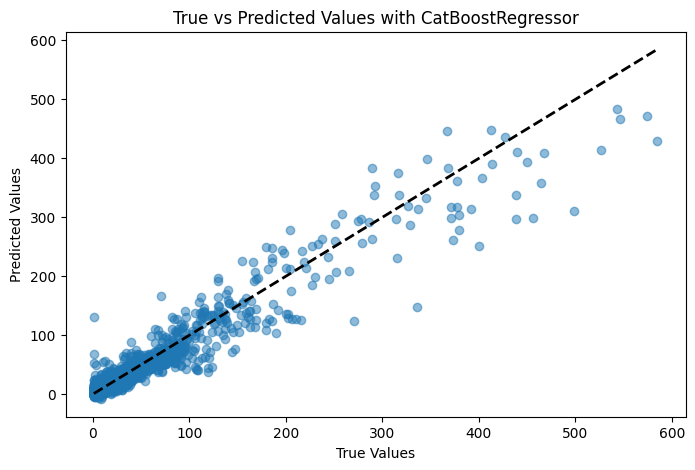

In [62]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_cat, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values with CatBoostRegressor')
plt.show()

In [ ]:

param_grid_gb = {'gradientboostingregressor__n_estimators': [100, 200,300],'gradientboostingregressor__max_depth': [6, 8],
                 'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1], 'gradientboostingregressor__min_samples_leaf': [5, 10, 15],
                 'gradientboostingregressor__random_state': [5, 10], 'gradientboostingregressor__min_samples_split':[2,4]}


pipe_gb = make_pipeline(StandardScaler(), GradientBoostingRegressor())
grid_search_gb = GridSearchCV(estimator=pipe_gb, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error',  n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
best_params_gb = grid_search_gb.best_params_
print("Best parameters found for RandomForestRegressor: ", best_params_gb)

In [ ]:
best_params_gb

In [ ]:
gb_model=GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5))

pipe_gb=make_pipeline(StandardScaler(),cat)
pipe_gb.fit(X_train, y_train)
y_pred_gb=pipe_gb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_gb)
print(f'Mean Absolute Error: {mae}')

### ensemble regressor

In [ ]:
from sklearn.ensemble import StackingRegressor
base_models = [
    ('lg',lgb.LGBMRegressor(learning_rate= 0.003,max_depth=10, n_estimator=100,max_features='auto',min_samples_leaf=1,min_samples_split=2)),#lgb.LGBMRegressor()),
    ('GB',GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)),
   ('cat', CatBoostRegressor(iterations=2000,learning_rate=0.009, depth=6, l2_leaf_reg=2, random_strength=5,bagging_temperature=0.2,border_count=256,eval_metric='RMSE')),

]

meta_model = ExtraTreesRegressor(n_estimators=200,min_samples_leaf=3,min_samples_split=8,max_features='auto',verbose=False,random_state=42)#ExtraTreesRegressor(n_estimators=300,verbose=False,random_state=42)#LinearRegression()

stack_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model,verbose=False)


pipe = make_pipeline( stack_reg)
pipe.fit(X_train,y_train)

y_prep_stag=pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_prep_stag)
print(f'Mean Absolute Error: {mae}')

## EDA

### Best Sellers

In [ ]:


item_sales = merged_data.groupby('Article')['Quantity'].sum().reset_index()

top_sellers = item_sales.sort_values(by='Quantity', ascending=False).head(10)

print("Top Selling Items:")
print(top_sellers)

plt.figure(figsize=(12, 8))
sns.barplot(x='Quantity', y='Article', data=top_sellers, palette='viridis')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.title('Top Selling Items')
plt.show()

### Daily Sale vs Weekend, Holidays, Rainy day

In [ ]:

from matplotlib.lines import Line2D
plt.figure(figsize=(14, 7))


plt.hist(rainy_dates, bins=30, alpha=0.2, color='steelblue', label='Precipitation (Rain)')

weekend_dates = merged_data[merged_data['is_weekend'] == 1]['date'].unique()
for weekend in weekend_dates:
    plt.axvline(x=weekend, color='red', linestyle='--', alpha=0.6,linewidth=0.8)
holiday_dates = merged_data[merged_data['is_holiday'] == 1]['date'].unique()
for holiday in holiday_dates:
    plt.axvline(x=holiday, color='green', linestyle='--', alpha=0.6,linewidth=0.8)

plt.plot(merged_data.groupby('date')['Quantity'].sum(), label='Total Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.title('Total Quantity Sold Over Time')
legend_elements = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=0.8, label='Weekends'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=0.7, label='Holidays'),
    Line2D([0], [0], color='steelblue', alpha=0.4, linewidth=10, label='Precipitation (Rain)')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


### Quantity sold vs day of the week


In [ ]:
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='Quantity', data=merged_data)
plt.xlabel('Day of Week')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold by Day of the Week')
plt.show()


In [ ]:
heatmap_data = merged_data.pivot(index='date', columns='date', values='quantity_sold')

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Quantity Sold'})
plt.title('Quantity Sold by Day with Weather Background')
plt.xlabel('Date')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

## Limitation


1.   'tsun' has no data
2.   'snow' feature only has 15 rows of data
3.   'date' has gap in between



In [ ]:
def find_missing_dates(df:pd.DataFrame)->pd.DataFrame:
  """
  Finds date gaps in the given DataFrame.

  Args:
    dataset of weather or bakery
  Returns:
    returns date gaps
  """
  min_date = merged_data['date'].min()
  max_date = merged_data['date'].max()
  date_range = pd.date_range(start=min_date, end=max_date, freq='D')

  missing_dates = date_range[~date_range.isin(merged_data['date'])]

  return missing_dates

missing_dates = find_missing_dates(backery)
heading='<h3> Limitation in data</h3>'
title='<h4>Following dates are missing in the bakery dataset </h4>'
display(HTML(heading))
display(HTML(title))
print(missing_dates)
